In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import re
import nltk, wordcloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
data = pd.read_csv(r"C:\Users\dell\Desktop\MyDocs\Docs\MK\output_sa.csv", encoding="ISO-8859-1")
data.head(7)

,id,app_id,content,author_id,is_positive
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative
5,176118004,100,Every enemy and their grandmother have aimbot ...,76561198296823531,Negative
6,172896379,100,l,76561199182060159,Negative


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201151 entries, 0 to 201150
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           201151 non-null  int64 
 1   app_id       201151 non-null  int64 
 2   content      200723 non-null  object
 3   author_id    201151 non-null  int64 
 4   is_positive  201151 non-null  object
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


In [18]:
data.shape

(201151, 5)

In [21]:
# calculate the current class distribution
original_distribution = data['is_positive'].value_counts(normalize=True)

# select N samples while maintaining the same class distribution
sampled_data = data.groupby('is_positive', group_keys=False).apply(
    lambda x: x.sample(n=int(40000 * original_distribution[x.name]), random_state=42)
)

# reset the index of the sampled dataset
sampled_data = sampled_data.reset_index(drop=True)

# verify the new shape
print("Original shape:", data.shape)
print("Sampled shape:", sampled_data.shape)

# verify the class distribution is maintained
print("\nOriginal class distribution:")
print(data['is_positive'].value_counts(normalize=True))
print("\nSampled class distribution:")
print(sampled_data['is_positive'].value_counts(normalize=True))


Original shape: (201151, 5)
Sampled shape: (39999, 5)

Original class distribution:
is_positive
Positive    0.510363
Negative    0.489637
Name: proportion, dtype: float64

Sampled class distribution:
is_positive
Positive    0.510363
Negative    0.489637
Name: proportion, dtype: float64


C:\Users\dell\AppData\Local\Temp\ipykernel_25908\2491525943.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('is_positive', group_keys=False).apply(


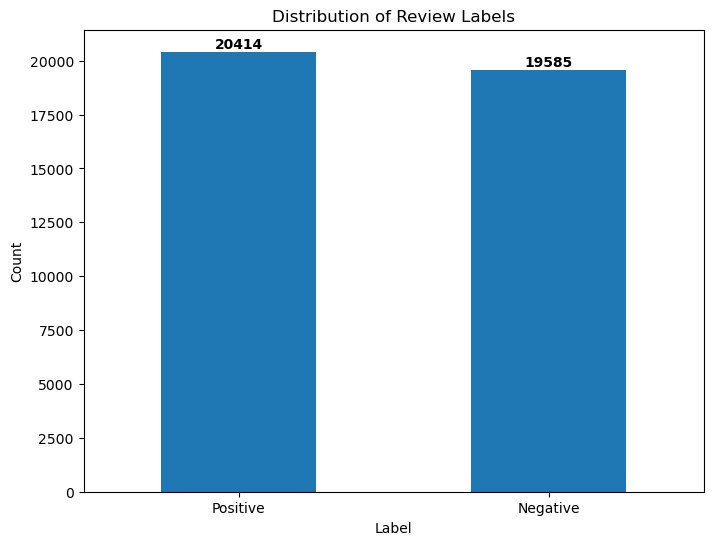

In [23]:
# create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = sampled_data['is_positive'].value_counts().plot(kind='bar')
plt.title('Distribution of Review Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# add value annotations on top of each bar
for i, v in enumerate(sampled_data['is_positive'].value_counts()):
    ax.text(i, v, str(v), 
            ha='center', va='bottom',
            fontweight='bold')

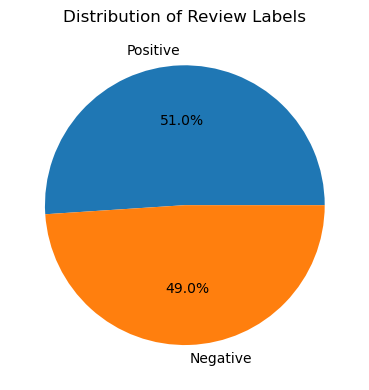

In [25]:
# pie Chart
plt.figure(figsize=(7, 4))
sampled_data['is_positive'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Review Labels')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [27]:
def preprocess_text(text):
    # convert to lowercase
    text = str(text).lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into text
    return ' '.join(tokens)

# applying preprocessing to the 'content' column
sampled_data['cleaned_content'] = sampled_data['content'].apply(preprocess_text)

In [28]:
# displaying a few examples of original and cleaned text
print("Original vs Cleaned Text Examples:")
for i in range(3):
    print("\nOriginal:", sampled_data['content'].iloc[i])
    print("Cleaned:", sampled_data['cleaned_content'].iloc[i])

Original vs Cleaned Text Examples:

Original: BROKEN UPDATE
Cleaned: broken update

Original: I PLAYED FOR A FEW HOURS I GUESS AND MY EYES STARTED BLEEDING BECAUSE OF THE GRAPHIC TEXTURES WERE SO GOOD LOOKING. EVEN VALVE SHOULD HAVE SOME SHAME AND REMOVE THIS GAME FROM THE STEAM STORE. CALL OF DUTY KILLED COUNTER STRIKE. WHY CANNOT I JUST SHOOT THE C4 OR WHY CAN'T I GET A C4 WITH A DETONATOR LIKE BATTLEFIELD OR CALL OF DUTY.  VALVE, NEXON, TURTLE ROCK, RITUAL, NAMCO AND FEW MORE STILL COULD NOT MAKE AIM DOWN SIGHTS INSTEAD OF A â.
Cleaned: played hour guess eye started bleeding graphic texture good looking even valve shame remove game steam store call duty killed counter strike shoot c cant get c detonator like battlefield call duty valve nexon turtle rock ritual namco still could make aim sight instead

Original: éå¸¸åå¾çæ¸¸æ
ä½¿æçé«ç©æè½¬
Cleaned: 


In [29]:
sampled_data.head(7)

,id,app_id,content,author_id,is_positive,cleaned_content
0,137600376,570,BROKEN UPDATE,76561198274016819,Negative,broken update
1,69993022,10,I PLAYED FOR A FEW HOURS I GUESS AND MY EYES S...,76561198344468891,Negative,played hour guess eye started bleeding graphic...
2,177389629,730,éå¸¸åå¾çæ¸¸æ\r\nä½¿æçé«ç©æè½¬,76561199153293128,Negative,
3,121281463,570,Couldn't find a match after queing for 3 hours...,76561199380100150,Negative,couldnt find match queing hour straight
4,180611857,730,cheater heaven,76561199241532224,Negative,cheater heaven
5,77132756,620,ass,76561198859334154,Negative,as
6,176664927,570,"Shit game, matchmaking is rigged on high ELO, ...",76561198047365972,Negative,shit game matchmaking rigged high elo mmr trad...


### Word Count Analysis ###


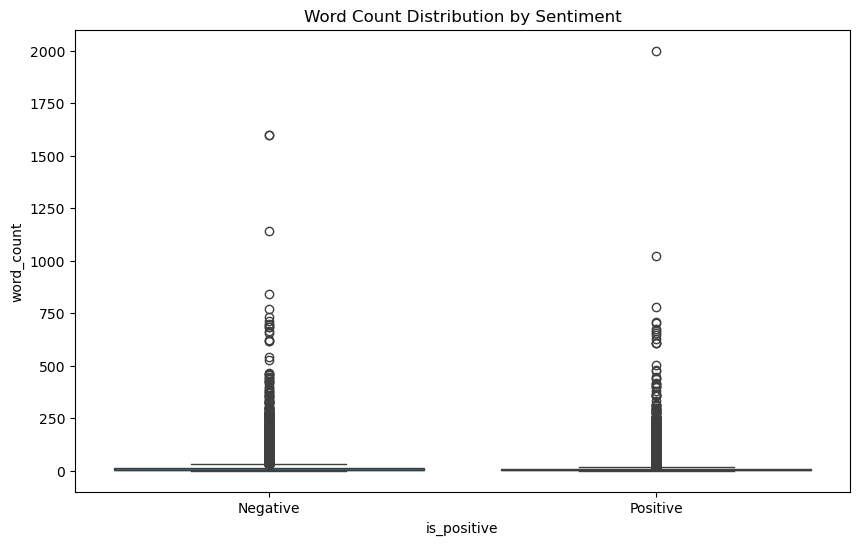

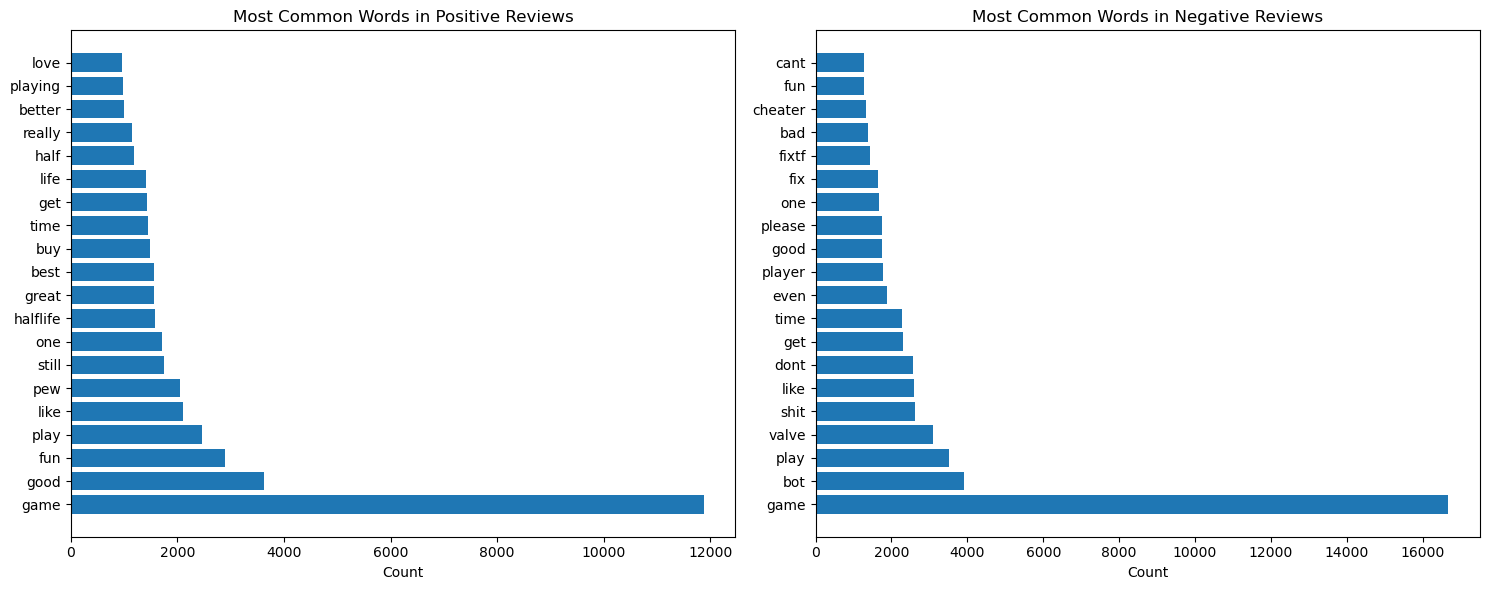


### Text Length Statistics ###

Positive Reviews:
count    20414.000000
mean        11.291712
std         33.767116
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       2000.000000
Name: word_count, dtype: float64

Negative Reviews:
count    19585.000000
mean        15.901557
std         40.574937
min          0.000000
25%          2.000000
50%          5.000000
75%         14.000000
max       1600.000000
Name: word_count, dtype: float64


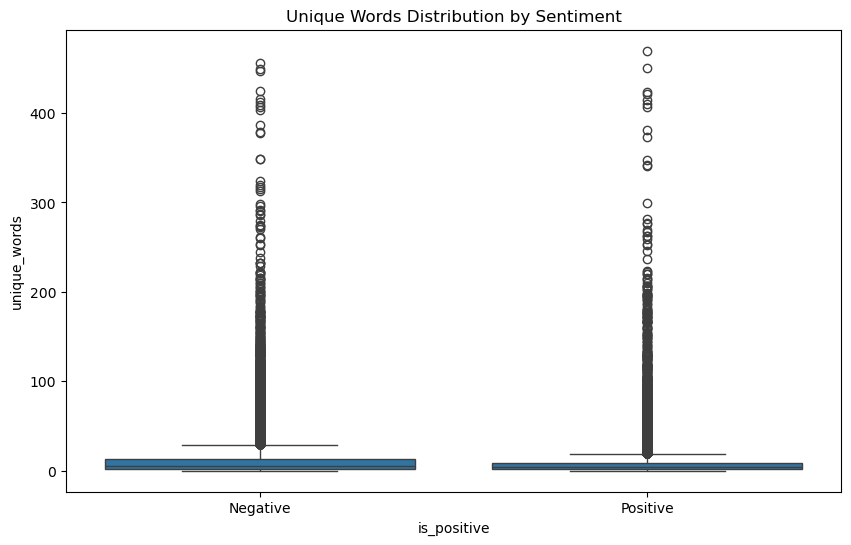

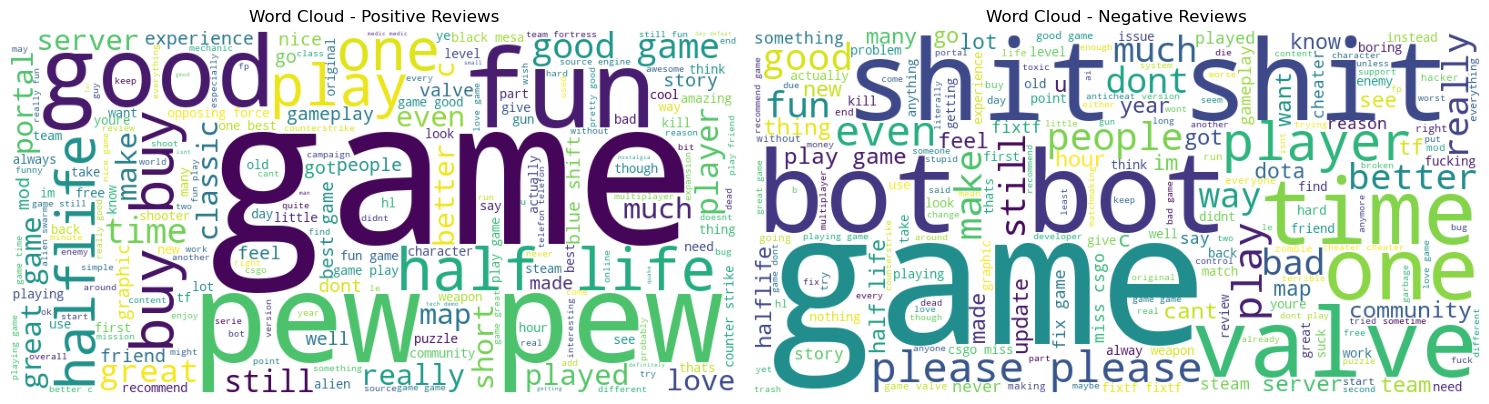

In [33]:
# 1. Word Count Analysis
print("### Word Count Analysis ###")
sampled_data['word_count'] = sampled_data['cleaned_content'].str.split().str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_positive', y='word_count', data=sampled_data)
plt.title('Word Count Distribution by Sentiment')
plt.show()

# 2. Most Common Words Analysis
from collections import Counter
import itertools

def get_most_common_words(texts, n=20):
    words = list(itertools.chain(*[text.split() for text in texts]))
    return Counter(words).most_common(n)

# Separating positive and negative reviews
positive_reviews = sampled_data[sampled_data['is_positive'] == 'Positive']['cleaned_content']
negative_reviews = sampled_data[sampled_data['is_positive'] == 'Negative']['cleaned_content']

# Getting most common words for each sentiment
pos_common_words = get_most_common_words(positive_reviews)
neg_common_words = get_most_common_words(negative_reviews)

# Plotting most common words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Positive reviews
words, counts = zip(*pos_common_words)
ax1.barh(words, counts)
ax1.set_title('Most Common Words in Positive Reviews')
ax1.set_xlabel('Count')

# Negative reviews
words, counts = zip(*neg_common_words)
ax2.barh(words, counts)
ax2.set_title('Most Common Words in Negative Reviews')
ax2.set_xlabel('Count')

plt.tight_layout()
plt.show()

# 3. Text Length Statistics
print("\n### Text Length Statistics ###")
print("\nPositive Reviews:")
print(sampled_data[sampled_data['is_positive'] == 'Positive']['word_count'].describe())
print("\nNegative Reviews:")
print(sampled_data[sampled_data['is_positive'] == 'Negative']['word_count'].describe())

# 4. Unique Words Analysis
def count_unique_words(text):
    return len(set(text.split()))

sampled_data['unique_words'] = sampled_data['cleaned_content'].apply(count_unique_words)

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_positive', y='unique_words', data=sampled_data)
plt.title('Unique Words Distribution by Sentiment')
plt.show()

# 5. Word Cloud Visualization
from wordcloud import WordCloud

plt.figure(figsize=(15, 6))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
positive_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos)
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

# Negative reviews word cloud
plt.subplot(1, 2, 2)
negative_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg)
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
# initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# fitting the vectorizer on the cleaned content
X_tfidf = tfidf_vectorizer.fit_transform(sampled_data['cleaned_content'])

In [37]:
# displaying the shape of the TF-IDF matrix
X_tfidf.shape

(39999, 5000)

In [39]:
# selection of target variable
y = (sampled_data['is_positive'] == 'Positive').astype(int)

y.shape

(39999,)

In [41]:
X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, 
                                                                            y, 
                                                                            test_size=0.2, 
                                                                            random_state=42, 
                                                                            stratify=y)

# displaying the shape of the training and testing sets
X_tfidf_train.shape, X_tfidf_test.shape, y_train_tfidf.shape, y_test_tfidf.shape

((31999, 5000), (8000, 5000), (31999,), (8000,))

In [43]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} with {vectorizer_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} ({vectorizer_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Random Forest with TF-IDF
Accuracy: 79.89%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      3917
           1       0.78      0.84      0.81      4083

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



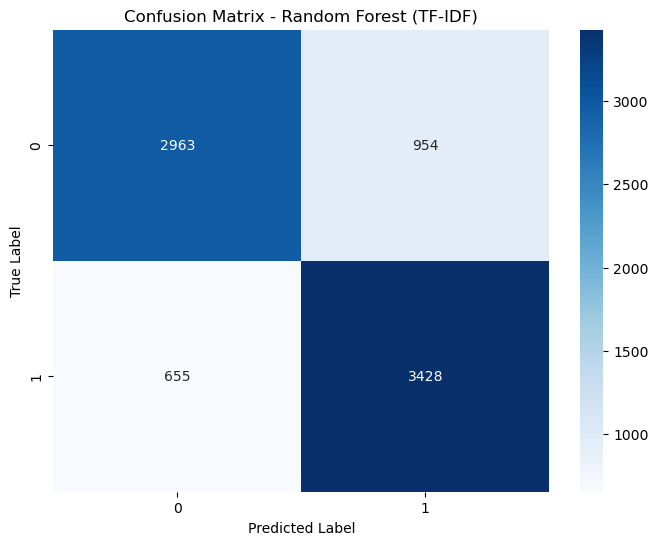

CPU times: total: 57.6 s
Wall time: 1min 24s


In [45]:
%%time
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=42)
# applying the model   
evaluate_model(rf, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Random Forest", "TF-IDF")


Support Vector Machine with TF-IDF
Accuracy: 80.77%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      3917
           1       0.78      0.86      0.82      4083

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



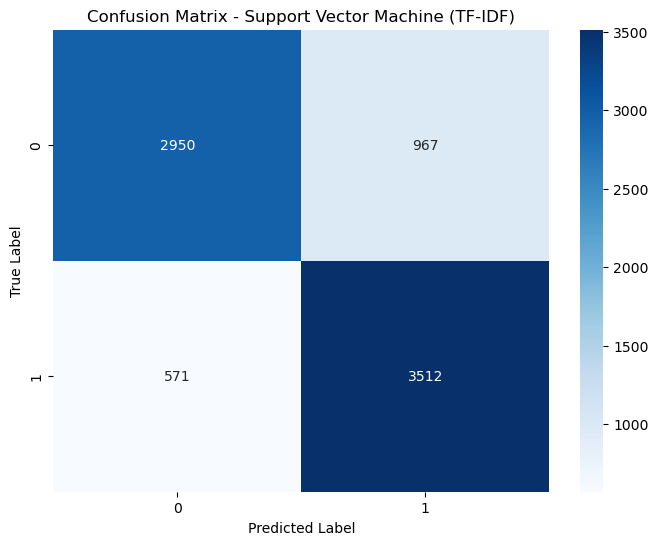

CPU times: total: 1min 10s
Wall time: 1min 19s


In [46]:
%%time
svm = SVC(kernel='linear', random_state=42)

# applying the model   
evaluate_model(svm, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Support Vector Machine", "TF-IDF")  


Naive Bayes with TF-IDF
Accuracy: 80.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      3917
           1       0.78      0.87      0.82      4083

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



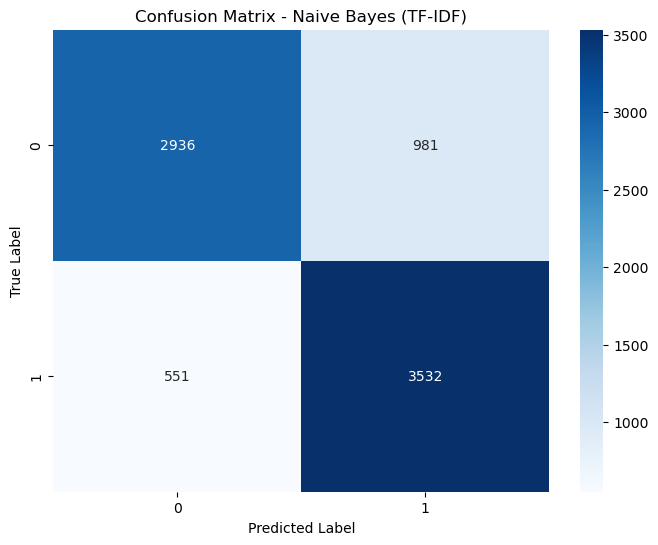

CPU times: total: 203 ms
Wall time: 250 ms


In [47]:
%%time
nb = MultinomialNB()

# applying the model   
evaluate_model(nb, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Naive Bayes", "TF-IDF")

<BarContainer object of 3 artists>

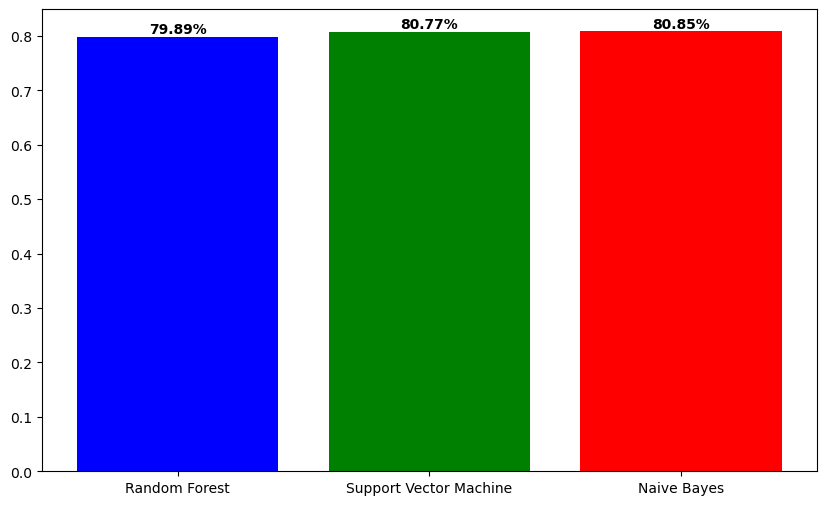

In [48]:
# bar chart for model comparison
fig, ax = plt.subplots(figsize=(10, 6))

# adding annotations to the bars
for i, v in enumerate([accuracy_score(y_test_tfidf, rf.predict(X_tfidf_test)), 
                      accuracy_score(y_test_tfidf, svm.predict(X_tfidf_test)), 
                      accuracy_score(y_test_tfidf, nb.predict(X_tfidf_test))]):
    ax.text(i, v, f"{v*100:.2f}%", 
            ha='center', va='bottom', 
            fontweight='bold')

# plotting the accuracy scores
ax.bar(['Random Forest', 'Support Vector Machine', 'Naive Bayes'], 
       [accuracy_score(y_test_tfidf, rf.predict(X_tfidf_test)), 
        accuracy_score(y_test_tfidf, svm.predict(X_tfidf_test)), 
        accuracy_score(y_test_tfidf, nb.predict(X_tfidf_test))], 
       color=['blue', 'green', 'red'])

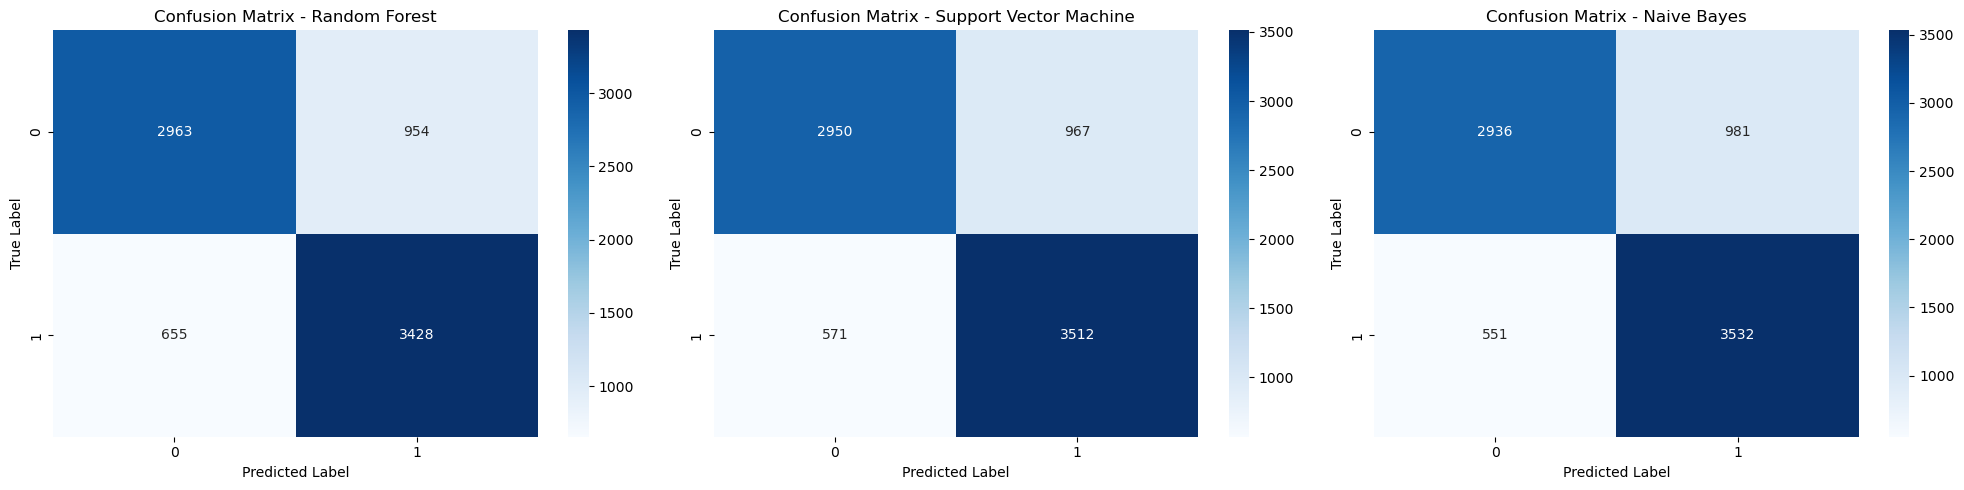

In [49]:
# Create a function to plot confusion matrices side by side
def plot_confusion_matrices(models, X_test, y_test, model_names):
   # create subplots in a single row
   fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
   
   for i, (model, name) in enumerate(zip(models, model_names)):
       # get predictions
       y_pred = model.predict(X_test)
       
       # calculate confusion matrix
       cm = confusion_matrix(y_test, y_pred)
       
       # plot confusion matrix
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
       axes[i].set_title(f'Confusion Matrix - {name}')
       axes[i].set_ylabel('True Label')
       axes[i].set_xlabel('Predicted Label')
   
   plt.tight_layout()
   plt.show()

# Create list of models and their names
models = [rf, svm, nb]
model_names = ['Random Forest', 'Support Vector Machine', 'Naive Bayes']

# Plot all confusion matrices
plot_confusion_matrices(models, X_tfidf_test, y_test_tfidf, model_names)


In [50]:
def print_sample_predictions(model, X_test, y_test, original_texts, n_samples):
    # get predictions
    y_pred = model.predict(X_test)
    
    # get original texts (assuming they're in the same order as X_test)
    sample_indices = np.random.choice(len(y_test), n_samples, replace=False)
    
    print("\nSample Predictions vs Actual Labels:")
    print("-" * 80)
    
    for idx in sample_indices:
        print(f"Text: {original_texts[idx]}")
        print(f"Predicted: {'Positive' if y_pred[idx] == 1 else 'Negative'}")
        print(f"Actual: {'Positive' if y_test.iloc[idx] == 1 else 'Negative'}")
        print("-" * 80)

In [51]:
print_sample_predictions(rf, X_tfidf_test, y_test_tfidf, sampled_data['content'], n_samples=5)


Sample Predictions vs Actual Labels:
--------------------------------------------------------------------------------
Text: Nice and fun game, but I managed to beat it in less than 3 hours, that is way too short in my opinion. Better to go for Portal 2 straight away.
Predicted: Negative
Actual: Negative
--------------------------------------------------------------------------------
Text: cs:go very nice, cs2 very not nice
Predicted: Negative
Actual: Negative
--------------------------------------------------------------------------------
Text: Pls valve
Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------
Text: make it available on Mac

Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------
Text: Cheater-Strike 2
Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------


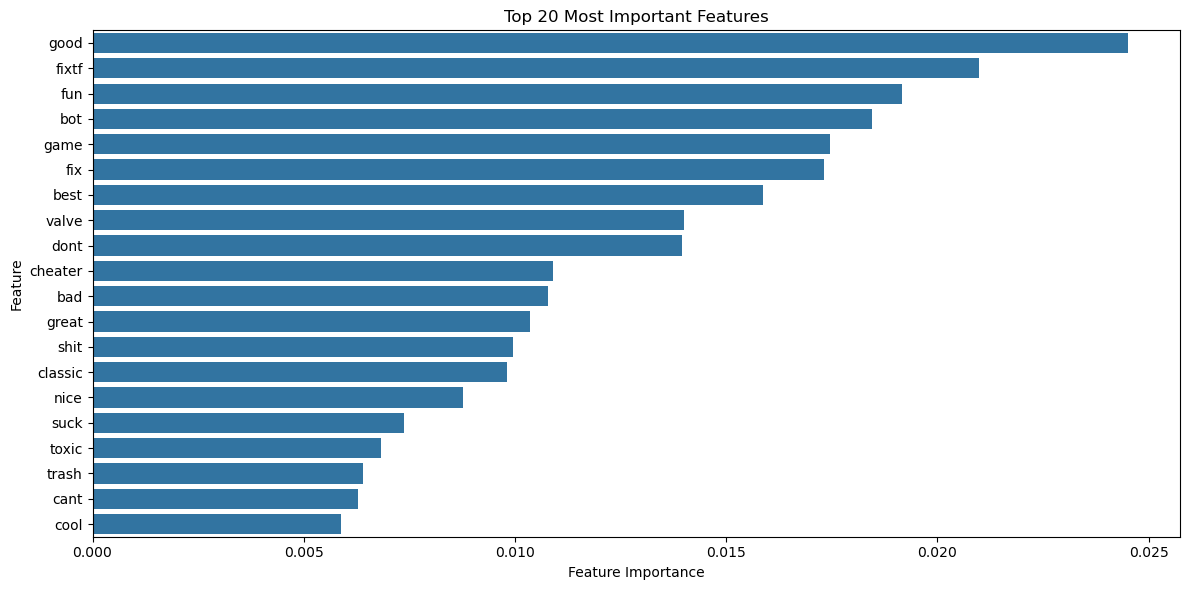


Top feature importance scores:
good: 0.0245
fixtf: 0.0210
fun: 0.0192
bot: 0.0184
game: 0.0175
fix: 0.0173
best: 0.0159
valve: 0.0140
dont: 0.0140
cheater: 0.0109
bad: 0.0108
great: 0.0104
shit: 0.0099
classic: 0.0098
nice: 0.0088
suck: 0.0074
toxic: 0.0068
trash: 0.0064
cant: 0.0063
cool: 0.0059


In [52]:
def visualize_feature_importance(rf_model, vectorizer, n_features=20):
    
    # get feature names and importance scores
    feature_names = vectorizer.get_feature_names_out()
    importances = rf_model.feature_importances_
    
    # create a dataframe of features and their importance scores
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # sort by importance and get top n_features
    top_features = feature_importance.sort_values('importance', ascending=False).head(n_features)
    
    # create the visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top {n_features} Most Important Features')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # print the numerical values
    print("\nTop feature importance scores:")
    for idx, row in top_features.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

# call the function
visualize_feature_importance(rf, tfidf_vectorizer)